In [223]:
import pandas as pd
import numpy as np
import torch

from collections import namedtuple
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
#Load data
path = "../data/"

#Ratings
ratings = pd.read_csv(path+'ratings.dat', sep='::', header=None, engine='python')
ratings.columns = ['userId','movieId','rating','timestamp']


#Movies
movies = pd.read_csv(path+'movies.dat', sep='::', header=None, engine='python')
movies.columns = ['movieId','title','genres']

#Users
users = pd.read_csv(path+'users.dat', sep='::', header=None, engine='python')
users.columns = ['userId','gender','age','occupation','zipCode']

In [173]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_movies))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_movies) * 100))

Duplicated rows in ratings file: 0
Number of users: 6040
Number of movies: 3706
Sparsity: 4.468%


## preprocessing to get the data ready

In [174]:
#drop the timestamp
ratings = ratings.drop('timestamp', axis=1)

In [175]:
movies['genres'] = movies.apply(lambda row : row['genres'].split("|")[0],axis=1)

In [176]:
#create a movie year column
movies['movie_year'] = movies.apply(lambda row : int(row['title'].split("(")[-1][:-1]),axis=1)

In [177]:
#drop the title column
movies.drop(['title'],axis=1,inplace=True)

In [178]:
rating_movie = pd.merge(ratings,movies,how='left',on="movieId")

In [179]:
#replace gender values with 0,1
users['gender'].replace({'F':0,'M':1},inplace=True)

In [180]:
#replace age with an ordered list for the age
users['age'].replace({1:0,18:1, 25:2, 35:3, 45:4, 50:5, 56:6 },inplace=True)

In [181]:
#one got encode the zipcode column 
#users = pd.get_dummies(users,prefix=['zipcode'],columns=["zipCode"],drop_first=True)
users.drop(['zipCode'],axis=1,inplace=True)

In [182]:
final_df = pd.merge(rating_movie,users,how='left',on='userId')

In [183]:
final_df.head()

,userId,movieId,rating,genres,movie_year,gender,age,occupation
0,1,1193,5,Drama,1975,0,0,10
1,1,661,3,Animation,1996,0,0,10
2,1,914,3,Musical,1964,0,0,10
3,1,3408,4,Drama,2000,0,0,10
4,1,2355,5,Animation,1998,0,0,10


In [184]:
def encoder(df, cols=None):
    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return val_to_idx, df

In [185]:
#function used to break the data into test and train sets and make embedding of the data
def data_processing(df, wide_cols, embeddings_cols, continuous_cols, target,
    scale=False, def_dim=8):


    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols+continuous_cols

    # Extract the target and copy the dataframe so we don't mutate it
    # internally.
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols ))
    df_tmp = df.copy()[all_columns]


    # Extract the categorical column names that can be one hot encoded later
    categorical_columns = list(df_tmp.select_dtypes(include=['object']).columns)

    
    encoding_dict,df_tmp = encoder(df_tmp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
    embeddings_input = []
    for k,v in encoding_dict.items():
        embeddings_input.append((k, len(v), emb_dim[k]))

    df_deep = df_tmp[deep_cols]
    deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}


    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1))

    df_wide = df_tmp[wide_cols]
    del(df_tmp)
    dummy_cols = [c for c in wide_cols if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns=dummy_cols)

    X_train_deep, X_test_deep = train_test_split(df_deep.values, test_size=0.3, random_state=1463)
    X_train_wide, X_test_wide = train_test_split(df_wide.values, test_size=0.3, random_state=1463)
    y_train, y_test = train_test_split(Y, test_size=0.3, random_state=1981)

    group_dataset = dict()
    train_dataset = namedtuple('train_dataset', 'wide, deep, labels')
    test_dataset  = namedtuple('test_dataset' , 'wide, deep, labels')
    group_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, y_train)
    group_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, y_test)
    group_dataset['embeddings_input']  = embeddings_input
    group_dataset['deep_column_idx'] = deep_column_idx
    group_dataset['encoding_dict'] = encoding_dict

    return group_dataset


In [189]:
#settings for the data
wide_cols = ['movie_year','gender','age', 'occupation','genres','userId','movieId']
embeddings_cols = [('genres',20), ('userId',100), ('movieId',100)]
crossed_cols = ()
continuous_cols = ["movie_year","gender","age","occupation"]
target = 'rating'

In [190]:
#split the data and generate the embeddings
data_processed = data_processing(
        final_df, wide_cols,
        embeddings_cols,
        continuous_cols,
        target,
        scale=True)

/home/roxor/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [192]:
use_cuda = torch.cuda.is_available()

#Loadthe dataset
class DatasetLoader(Dataset):
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)


In [211]:

#class defining the wide and deep neural network
class NeuralNet(nn.Module):

    def __init__(self,
                 wide_dim,
                 embeddings_input,
                 continuous_cols,
                 deep_column_idx,
                 hidden_layers,
                 dropout,
                 encoding_dict,
                 n_class):

        super(NeuralNet, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class
        self.loss_values=[]

        # Build the embedding layers to be passed through the deep-side
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # Build the deep-side hidden layers with dropout if specified
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        # Connect the wide- and dee-side of the model to the output neuron(s)
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, self.n_class)


    def compile(self, optimizer="Adam", learning_rate=0.001, momentum=0.0):
        
        self.activation, self.criterion = None, F.mse_loss

        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        if optimizer == "RMSprop":
            self.optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)

        self.method = 'regression'


    def forward(self, X_w, X_d):

        # Deep Side
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X_d[:, cont_idx].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        # Deep + Wide sides
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)

        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):

        widedeep_dataset = DatasetLoader(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        # set the model in training mode
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                y_pred = torch.squeeze(y_pred)
                loss = self.criterion(y_pred, y)
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().data[0])
            self.loss_values.append(loss.item())
            print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                    round(loss.item(),3)))


    def predict(self, dataset):


        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()


 

    def get_embeddings(self, col_name):
        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {v:k for k,v in col_label_encoding.items()}
        embeddings_dict = {}
        for idx,value in inv_dict.items():
            embeddings_dict[value] = embeddings[idx]

        return embeddings_dict

In [212]:
# Network set up
wide_dim = data_processed['train_dataset'].wide.shape[1]
n_unique = len(np.unique(data_processed['train_dataset'].labels))
n_class = 1

deep_column_idx = data_processed['deep_column_idx']
embeddings_input= data_processed['embeddings_input']
encoding_dict   = data_processed['encoding_dict']
hidden_layers = [100,50]
dropout = [0.5,0.2]


In [213]:
use_cuda = torch.cuda.is_available()

model = NeuralNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer='Adam')
if use_cuda:
    model = model.cuda()

In [214]:
#train the model
train_dataset = data_processed['train_dataset']
model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)

Epoch 1 of 5, Loss: 1.025
Epoch 2 of 5, Loss: 3.416
Epoch 3 of 5, Loss: 0.428
Epoch 4 of 5, Loss: 1.753
Epoch 5 of 5, Loss: 1.596


In [215]:
test_dataset  = data_processed['test_dataset']

In [216]:
y_pred = model.predict(dataset=test_dataset)

In [217]:
y = test_dataset.labels

In [219]:
#get the test MSE
mean_squared_error(y_pred,y)

2.433546222449907

In [220]:
#get the test MAE
mean_absolute_error(y_pred,y)

1.2152028025234123

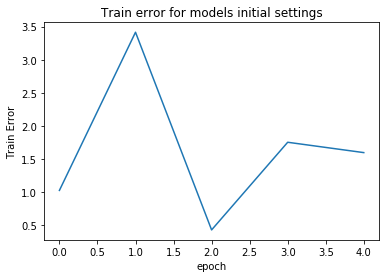

In [226]:
#plt the train error of model
plt.plot(model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')
plt.title("Train error for models initial settings")
plt.show()

## hyperparameter tuning

### for the gradient descent algorithm

In [227]:
models = []
methods = ["Adam","RMSprop"]

In [228]:
for method in methods:
    model = NeuralNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer=method)
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=5, batch_size=60)
    models.append(model)

Epoch 1 of 5, Loss: 0.715
Epoch 2 of 5, Loss: 1.09
Epoch 3 of 5, Loss: 0.877
Epoch 4 of 5, Loss: 1.614
Epoch 5 of 5, Loss: 1.835
Epoch 1 of 5, Loss: 10.65
Epoch 2 of 5, Loss: 2.685
Epoch 3 of 5, Loss: 7.214
Epoch 4 of 5, Loss: 8.189
Epoch 5 of 5, Loss: 8.036


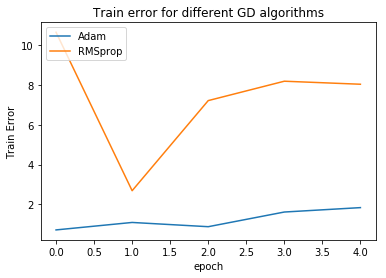

In [230]:
for model in models:
    plt.plot(np.arange(5),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(methods, loc='upper left')
plt.title("Train error for different GD algorithms")
plt.show()

In [234]:
for model in models:
    print("for "+ str(model.optimizer))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
test mean squared error: 3.8304705756688953
test mean absolute error: 1.6774666215667928
for RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
test mean squared error: 14.301679812034216
test mean absolute error: 3.4415117375038946


### optimizing dropout values

In [239]:
droupouts = [0,0.1,0.5]
models_dropout=[]

In [240]:
for droupout in droupouts:
    dropout = [droupout,droupout]
    model = NeuralNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer="Adam")
    if use_cuda:
        model = model.cuda()
    model.fit(dataset=train_dataset, n_epochs=3, batch_size=60)
    models_dropout.append(model)

Epoch 1 of 3, Loss: 0.686
Epoch 2 of 3, Loss: 3.3
Epoch 3 of 3, Loss: 1.797
Epoch 1 of 3, Loss: 2.098
Epoch 2 of 3, Loss: 0.771
Epoch 3 of 3, Loss: 4.375
Epoch 1 of 3, Loss: 1.159
Epoch 2 of 3, Loss: 0.724
Epoch 3 of 3, Loss: 1.163


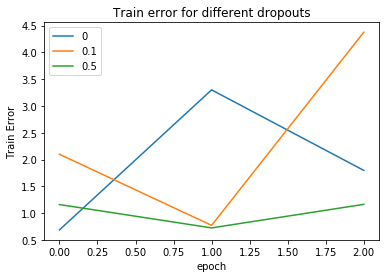

In [246]:
for model in models_dropout:
    plt.plot(np.arange(3),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.legend(droupouts, loc='upper left')
plt.title("Train error for different dropouts")
plt.show()

In [249]:
for model in models_dropout:
    print("for drououts: "+ str(model.dropout))
    y_pred = model.predict(dataset=test_dataset)
    y = test_dataset.labels
    print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
    print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

for drououts: [0, 0]
test mean squared error: 1.327298705029263
test mean absolute error: 0.9674445709737696
for drououts: [0.1, 0.1]
test mean squared error: 1.4589379506428217
test mean absolute error: 1.003326960903818
for drououts: [0.5, 0.5]
test mean squared error: 1.3582297251538353
test mean absolute error: 0.9704529255707942


## Evaluating the model with optimal hyperparameters

In [253]:
dropout = [0.5,0.5]
model = NeuralNet(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)
model.compile(optimizer="Adam")
if use_cuda:
    model = model.cuda()
model.fit(dataset=train_dataset, n_epochs=10, batch_size=60)

Epoch 1 of 10, Loss: 2.669
Epoch 2 of 10, Loss: 0.893
Epoch 3 of 10, Loss: 2.157
Epoch 4 of 10, Loss: 1.586
Epoch 5 of 10, Loss: 1.628
Epoch 6 of 10, Loss: 1.359
Epoch 7 of 10, Loss: 0.64
Epoch 8 of 10, Loss: 2.361
Epoch 9 of 10, Loss: 1.098
Epoch 10 of 10, Loss: 2.597


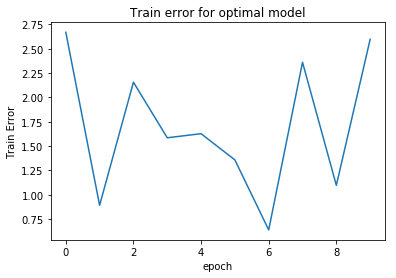

In [257]:
plt.plot(np.arange(10),model.loss_values)
plt.ylabel('Train Error')
plt.xlabel('epoch')

plt.title("Train error for optimal model")
plt.show()

In [258]:
y_pred = model.predict(dataset=test_dataset)
y = test_dataset.labels
print("test mean squared error: "+str(mean_squared_error(y_pred,y)))
print("test mean absolute error: "+ str(mean_absolute_error(y_pred,y)))

test mean squared error: 1.3538917806265323
test mean absolute error: 0.9229052796107362


### calcualte the time to run the model for different subsets

In [282]:
unique_users = final_df['userId'].unique()
user_quantiles = np.arange(0.1,1,0.1)
runtimes = []

In [283]:
import time
for quantile in user_quantiles:
    start_time = time.time()
    subset_users = unique_users[:int(len(unique_users)*quantile)]
    subset_df = final_df.loc[final_df['userId'].isin(subset_users)]
    data_processed = data_processing(
        subset_df, wide_cols,
        embeddings_cols,
        continuous_cols,
        target,
        scale=True)
    model = NeuralNet(
        wide_dim,
        embeddings_input,
        continuous_cols,
        deep_column_idx,
        hidden_layers,
        dropout,
        encoding_dict,
        n_class)
    model.compile(optimizer='Adam')
    if use_cuda:
        model = model.cuda()
    train_dataset = data_processed['train_dataset']
    model.fit(dataset=train_dataset, n_epochs=1, batch_size=60)
    end_time = time.time()
    total_time = end_time- start_time
    print("total time:" + str(total_time))
    runtimes.append(total_time)
    

/home/roxor/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1 of 1, Loss: 0.329
total time:2.0968427658081055
Epoch 1 of 1, Loss: 0.713
total time:4.748933792114258
Epoch 1 of 1, Loss: 0.85
total time:6.54540753364563
Epoch 1 of 1, Loss: 1.187
total time:9.715687036514282
Epoch 1 of 1, Loss: 1.218
total time:11.353285074234009
Epoch 1 of 1, Loss: 0.659
total time:13.029703378677368
Epoch 1 of 1, Loss: 0.407
total time:15.628254652023315
Epoch 1 of 1, Loss: 1.535
total time:17.98717498779297
Epoch 1 of 1, Loss: 2.209
total time:20.148995876312256


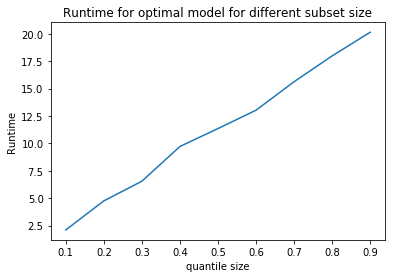

In [284]:
plt.plot(user_quantiles,runtimes)
plt.ylabel('Runtime')
plt.xlabel('quantile size')

plt.title("Runtime for optimal model for different subset size")
plt.show()